In [28]:
# 📈 Analyse des ventes Intermarché

# Cell 1: Imports et chargement des données
import os
DATA_PATH = 'data/dataset_case.csv'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from catboost import CatBoostRegressor
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ValueWarning


from sklearn.metrics import mean_absolute_error

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

# Chargement du CSV et mise en fréquence journalière
csv_path = 'data/dataset_case.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier '{csv_path}' est introuvable.")
df = pd.read_csv(csv_path, parse_dates=['transaction_date'])
df = df.set_index('transaction_date').sort_index().asfreq('D')

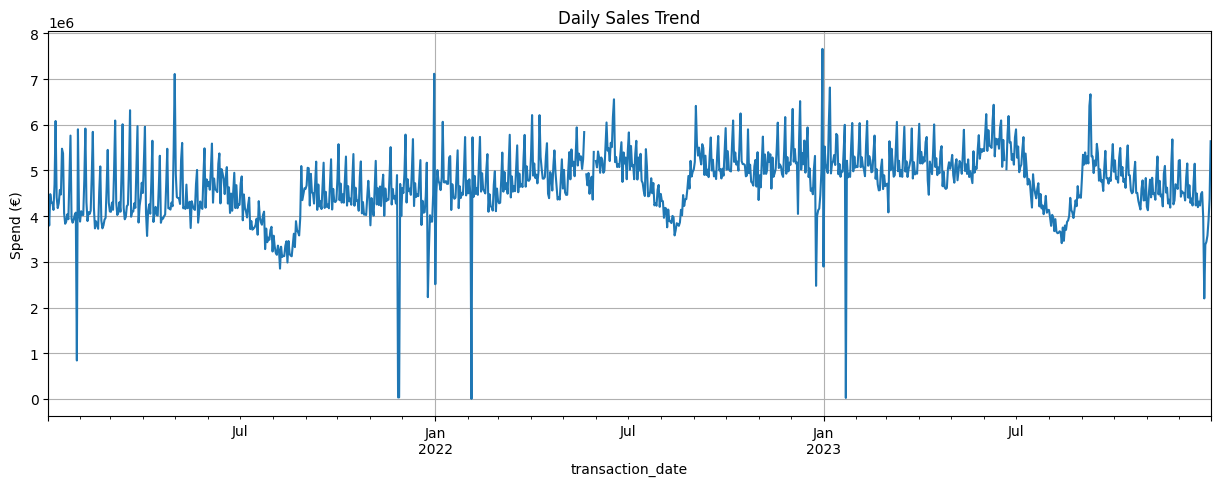

In [29]:
# Cell 2: Visualisations initiales
plt.figure(figsize=(15,5))
df['spend'].plot(title='Daily Sales Trend')
plt.ylabel('Spend (€)')
plt.grid(True)
plt.show()

In [30]:
# cell 2a : Vérification précise des dates manquantes

# Relire le CSV pour récupérer les dates brutes
df_dates = pd.read_csv('data/dataset_case.csv', parse_dates=['transaction_date'])
# Obtenir les dates uniques
unique_dates = pd.to_datetime(df_dates['transaction_date']).dt.normalize().drop_duplicates().sort_values()

# 1) Période réelle
start_csv = unique_dates.min().date()
end_csv   = unique_dates.max().date()

# 2) Totaux
n_lines  = len(df_dates)        # nombre de lignes dans le CSV
n_unique = len(unique_dates)    # nombre de dates uniques

# 3) Plage complète et dates manquantes
full_dates    = pd.date_range(start=start_csv, end=end_csv, freq='D')
n_full        = len(full_dates)
missing_dates = full_dates.difference(unique_dates)

# 4) Affichage clair
print(f"Période chargée    : {start_csv} → {end_csv}")
print(f"Lignes dans le CSV : {n_lines}")
print(f"Dates uniques      : {n_unique}")
print(f"Dates totales      : {n_full}")
print(f"→ {n_full - n_unique} date(s) manquante(s)\n")

if len(missing_dates) > 0:
    print("Dates manquantes détectées :")
    for d in missing_dates:
        print(" -", d.strftime("%Y-%m-%d"))
else:
    print("Aucune date manquante 🎉")

Période chargée    : 2021-01-02 → 2023-12-31
Lignes dans le CSV : 1091
Dates uniques      : 1091
Dates totales      : 1094
→ 3 date(s) manquante(s)

Dates manquantes détectées :
 - 2022-05-22
 - 2022-05-31
 - 2023-06-21


In [31]:
# cell 2b : Distribution interactive des ventes journalières (px.box)


pio.renderers.default = 'notebook_connected'

# 1) Préparation des dates en string
df_plot = df.reset_index().rename(columns={'transaction_date':'date'})
df_plot['date_str'] = df_plot['date'].dt.strftime('%Y-%m-%d')

# 2) Création de la boxplot interactive
fig = px.box(
    df_plot,
    x="spend",                   # variable à boxplotter
    points="outliers",           # seuls les outliers sont dessinés en points
    hover_data=["date_str"],     # on fournit la date au survol
    orientation="h"              # horizontal
)

# 3) Personnalisation du hover (seulement date + €)
fig.update_traces(
    hovertemplate=
      "Date : %{customdata[0]}<br>" +
      "Spend : %{x:,.2f} €<extra></extra>",
    marker=dict(color="orange", symbol="x", size=8)  # style des outliers
)

# 4) Ajout (optionnel) des lignes Moyenne/Médiane/Q1/Q3 si besoin
mean_val   = df['spend'].mean()
median_val = df['spend'].median()
q1, q3     = df['spend'].quantile([0.25, 0.75])

shapes, annotations = [], []
for label, value, color, ypos, align in [
    ('Q1 (25%))',  q1,   'purple', 0.2,  'right'),
    ('Moyenne',    mean_val,   'green',  0.45, 'center'),
    ('Médiane',    median_val, 'orange', 0.6,  'center'),
    ('Q3 (75%)',   q3,   'purple', 0.8,  'left'),
]:
    shapes.append(dict(
        type='line', x0=value, x1=value,
        y0=0, y1=1, xref='x', yref='paper',
        line=dict(color=color, dash='dash')
    ))
    annotations.append(dict(
        x=value, y=ypos, xref='x', yref='paper',
        text=f'{label} : {value:,.0f} €',
        showarrow=False,
        font=dict(color=color),
        align=align,
        bgcolor='rgba(255,255,255,0.8)'
    ))

# 5) Format de l’axe en euros
fig.update_xaxes(tickformat="€,.0f")
fig.update_layout(
    shapes=shapes,
    annotations=annotations,
    title="Interactive Distribution of Daily Sales",
    yaxis=dict(visible=False),
    margin=dict(l=40, r=40, t=60, b=40),
    showlegend=False
)

fig.show()
# Sauvegarder le graphique en tant que fichier HTML
fig.write_html("graphique_boxplot.html")


# Affichage des statistiques descriptives
desc = df['spend'].describe().to_frame().T
print(desc[['mean','50%','25%','75%']].rename(columns={'50%':'median'}))


               mean        median           25%           75%
spend  4.721010e+06  4.767960e+06  4.280151e+06  5.156066e+06


In [32]:
# cell 3 : Visualisation interactive des outliers et anomalies par type
q25, q75 = df['spend'].quantile([0.25,0.75])
iqr = q75 - q25
lower, upper = q25 - 1.5*iqr, q75 + 1.5*iqr

# Détection IQR
outliers_iqr = df[(df['spend'] < lower) | (df['spend'] > upper)]

# Isolation Forest
iso_model = IsolationForest(contamination=0.02, random_state=42).fit(df[['spend']])
df['iso_anomaly'] = iso_model.predict(df[['spend']]) == -1

# Prophet changepoints
prophet_df = df.reset_index()[['transaction_date','spend']].rename(columns={'transaction_date':'ds','spend':'y'})
m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(prophet_df)
forecast = m.predict(prophet_df)
diff = prophet_df['y'] - forecast['yhat']
threshold = diff.abs().quantile(0.98)
df['prophet_anomaly'] = df.index.isin(prophet_df.loc[diff.abs()>threshold,'ds'])

# 1) Choix du renderer inline
pio.renderers.default = 'notebook_connected'

# 2) Préparation du DataFrame de base
df_plot = df.reset_index().rename(columns={'transaction_date':'date'})

# 3) Construire un DataFrame par type d’anomalie
iqr_df = outliers_iqr.reset_index().rename(columns={'transaction_date':'date'})
iqr_df['type'] = 'IQR'

iso_df = df[df['iso_anomaly']].reset_index().rename(columns={'transaction_date':'date'})
iso_df['type'] = 'IsolationForest'

prop_df = prophet_df.loc[diff.abs()>threshold, ['ds','y']].rename(columns={'ds':'date','y':'spend'})
prop_df['type'] = 'Prophet'

# 4) Créer la figure
fig = go.Figure()

# Série principale
fig.add_trace(go.Scatter(
    x=df_plot['date'], y=df_plot['spend'],
    mode='lines',
    name='Series',
    line=dict(color='lightgray'),
    hovertemplate=
      'Date : %{x|%Y-%m-%d}<br>'+
      'Spend : %{y:.2f}€<br>' 
))

# Anomalies IQR
fig.add_trace(go.Scatter(
    x=iqr_df['date'], y=iqr_df['spend'],
    mode='markers',
    name='Outliers IQR',
    marker=dict(symbol='x', size=10, color='orange'),
    hovertemplate=
      'Date: %{x|%Y-%m-%d}<br>'+
      'Valeur: %{y:.2f}€<br>'+
      'Type: IQR'
))

# Anomalies IsolationForest
fig.add_trace(go.Scatter(
    x=iso_df['date'], y=iso_df['spend'],
    mode='markers',
    name='IsolationForest',
    marker=dict(symbol='circle', size=8, color='red'),
    hovertemplate=
      'Date: %{x|%Y-%m-%d}<br>'+
      'Valeur: %{y:.2f}€<br>'+
      'Type: IsolationForest'
))

# Anomalies Prophet Changepoints
fig.add_trace(go.Scatter(
    x=prop_df['date'], y=prop_df['spend'],
    mode='markers',
    name='Prophet Changepoints',
    marker=dict(symbol='square', size=8, color='purple'),
    hovertemplate=
      'Date: %{x|%Y-%m-%d}<br>'+
      'Valeur: %{y:.2f}€<br>'+
      'Type: Prophet'
))

# 5) Layout final
fig.update_layout(
    title="Daily Sales and Detected Anomalies",
    xaxis_title="Date",
    yaxis_title="Spend (€)",
    legend_title="Anomaly Type",
    hovermode="closest",
    legend=dict(
          x=0.5,  
          y=-0.2,  
          xanchor='center',  
          yanchor='top', 
          bgcolor='rgba(255, 255, 255, 0.5)', 
          bordercolor='rgba(0, 0, 0, 0.5)',  
          borderwidth=1,  
          orientation='h',
          itemwidth=30 
      )
)

# 6) Affichage inline
fig.show()
# Sauvegarder le graphique en tant que fichier HTML
fig.write_html("graphique_anomalies.html")


15:46:26 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] done processing


## Etape 1 : Méthodologie – Détection et traitement des valeurs extrêmes

Avant de construire nos modèles, une étape clé consiste à repérer les **outliers**, car ils peuvent biaiser les prévisions :
- **IQR (Interquartile Range)** : seuils Q1–1,5×IQR et Q3+1,5×IQR pour identifier les points inhabituels.
- **Validation ML** : Isolation Forest et Prophet changepoints pour confirmer les anomalies statistiques.
- **Exclusion des jours spéciaux** : fin d’année, fêtes nationales… ces pics business sont intacts (pas de clipping).
- Les flags `is_outlier`, `is_iso_anomaly` et `is_prophet_anomaly` seront réutilisés dans certains workflows.


In [33]:
# Cell 4: Jours fériés et création des flags
holidays = {
 '2021-01-01':'Nouvel An','2021-04-04':'Pâques','2021-04-05':'Lundi de Pâques','2021-05-01':'Fête du Travail',
 '2021-05-08':'Victoire','2021-05-13':'Ascension','2021-05-24':'Pentecôte','2021-07-14':'Fête nationale',
 '2021-08-15':'Assomption','2021-11-01':'Toussaint','2021-11-11':'Armistice','2021-12-25':'Noël',
 '2022-01-01':'Nouvel An','2022-04-17':'Pâques','2022-04-18':'Lundi de Pâques','2022-05-01':'Fête du Travail',
 '2022-05-08':'Victoire','2022-05-26':'Ascension','2022-06-06':'Pentecôte','2022-07-14':'Fête nationale',
 '2022-08-15':'Assomption','2022-11-01':'Toussaint','2022-11-11':'Armistice','2022-12-25':'Noël',
 '2023-01-01':'Nouvel An','2023-04-09':'Pâques','2023-04-10':'Lundi de Pâques','2023-05-01':'Fête du Travail',
 '2023-05-08':'Victoire','2023-05-18':'Ascension','2023-05-29':'Pentecôte','2023-07-14':'Fête nationale',
 '2023-08-15':'Assomption','2023-11-01':'Toussaint','2023-11-11':'Armistice','2023-12-25':'Noël',
 '2024-01-01':'Nouvel An','2024-03-31':'Pâques','2024-04-01':'Lundi de Pâques','2024-05-01':'Fête du Travail',
 '2024-05-08':'Victoire','2024-05-09':'Ascension','2024-05-20':'Pentecôte','2024-07-14':'Fête nationale',
 '2024-08-15':'Assomption','2024-11-01':'Toussaint','2024-11-11':'Armistice','2024-12-25':'Noël'
}
holiday_df = pd.DataFrame.from_dict(holidays, orient='index', columns=['name']).reset_index().rename(columns={'index':'date'})
display(holiday_df)

DF = df.reset_index().copy()
DF['is_outlier']           = DF['transaction_date'].isin(outliers_iqr.index).astype(int)
DF['is_iso_anomaly']       = DF['transaction_date'].isin(df.index[df['iso_anomaly']]).astype(int)
DF['is_prophet_anomaly']   = DF['transaction_date'].isin(prophet_df['ds']).astype(int)
DF['dayofweek']            = DF['transaction_date'].dt.dayofweek
DF['is_holiday']           = DF['transaction_date'].dt.strftime('%Y-%m-%d').isin(holidays.keys()).astype(int)

display(DF.head())


,date,name
0,2021-01-01,Nouvel An
1,2021-04-04,Pâques
2,2021-04-05,Lundi de Pâques
3,2021-05-01,Fête du Travail
4,2021-05-08,Victoire
5,2021-05-13,Ascension
6,2021-05-24,Pentecôte
7,2021-07-14,Fête nationale
8,2021-08-15,Assomption
9,2021-11-01,Toussaint


,transaction_date,spend,iso_anomaly,prophet_anomaly,is_outlier,is_iso_anomaly,is_prophet_anomaly,dayofweek,is_holiday
0,2021-01-02,4.337302e+06,False,False,0,0,1,5,0
1,2021-01-03,3.795543e+06,False,False,0,0,1,6,0
2,2021-01-04,4.481645e+06,False,False,0,0,1,0,0
3,2021-01-05,4.292265e+06,False,False,0,0,1,1,0
4,2021-01-06,4.295346e+06,False,False,0,0,1,2,0


In [34]:
# Cell 5: Préparation train/test
DF.set_index('transaction_date', inplace=True)
train_end, test_start, test_end = '2023-10-31', '2023-11-01', '2023-12-31'
y_train = DF.loc[:train_end, 'spend']
y_test  = DF.loc[test_start:test_end, 'spend']


## Etape 2 : Choix méthodologiques – Panorama des modèles

Pour couvrir différentes dynamiques de la série :
- **SARIMA** : décomposition auto-rég./saison. classique, bonne baseline pour la saisonnalité.
- **SARIMAX (+exogènes)** : on enrichit SARIMA avec `dayofweek`, `is_holiday`, `is_outlier` ; attention au risque de sur-ajustement.
- **RandomForest** : arbre non linéaire, capture interactions et lags, facilement interprétable via importance des features.
- **Prophet** : composantes de tendance/saison personnalisables, gestion native des holidays.
- **CatBoost** : gradient boosting optimisé, capte finement non-linéarités et variables catégorielles (flags).


In [35]:
# Cell 6: Workflow 1 - Winsorizing (hors fériés) + SARIMA
Q1, Q3 = DF['spend'].quantile([0.25, 0.75]); IQR = Q3 - Q1
winsor = DF.copy()
mask_hol = winsor['is_holiday']==1
winsor['spend_winsor'] = np.where(mask_hol, winsor['spend'], winsor['spend'].clip(Q1-1.5*IQR, Q3+1.5*IQR))

model_sarima = SARIMAX(
    winsor.loc[:train_end, 'spend_winsor'],
    order=(2,1,2), seasonal_order=(1,1,1,7),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)

pred_sarima_test = model_sarima.get_forecast(steps=len(y_test)).predicted_mean
pred_sarima_test.index = y_test.index
pred_sarima_jan = model_sarima.get_forecast(steps=len(y_test)+31).predicted_mean.iloc[len(y_test):]
pred_sarima_jan.index = pd.date_range('2024-01-01','2024-01-31',freq='D')

warnings.filterwarnings("ignore", category=ValueWarning)
print("SARIMA Winsor MAE test:", np.mean(np.abs(pred_sarima_test - y_test)))

SARIMA Winsor MAE test: 268151.9845028179


In [36]:
# Cell 6b: SARIMAX + flags exogènes & MAE
winsor = winsor.asfreq('D')
exog_vars   = ['dayofweek', 'is_holiday', 'is_outlier']
exog_train  = winsor.loc[:train_end, exog_vars].asfreq('D')
endog_train = winsor.loc[:train_end, 'spend_winsor'].asfreq('D')

model_sarimax_exog = SARIMAX(
    endog_train, exog=exog_train,
    order=(2,1,2), seasonal_order=(1,1,1,7),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False, maxiter=200)

exog_test      = winsor.loc[test_start:test_end, exog_vars].asfreq('D')
pred_exog_test = model_sarimax_exog.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean
pred_exog_test.index = y_test.index

# ► Prédiction pour Janvier 2024
jan_idx = pd.date_range('2024-01-01','2024-01-31',freq='D')
exog_jan = pd.DataFrame({
    'dayofweek':  jan_idx.dayofweek,
    'is_holiday': jan_idx.strftime('%Y-%m-%d').isin(holidays.keys()).astype(int),
    'is_outlier': 0
}, index=jan_idx)

pred_exog_jan = model_sarimax_exog.get_forecast(
    steps=len(jan_idx), exog=exog_jan
).predicted_mean
pred_exog_jan.index = jan_idx

from sklearn.metrics import mean_absolute_error
mae_exog = mean_absolute_error(y_test, pred_exog_test)
print(f"SARIMAX (+ flags) MAE test: {mae_exog:.2f}")


SARIMAX (+ flags) MAE test: 455234.16


In [37]:
# Cell 7: Workflow 2 - Flags + RandomForest
features = ['dayofweek','is_holiday','is_outlier'] + [f'lag_{i}' for i in range(1,8)]
rf_df = DF[['spend']].copy()
for i in range(1,8): rf_df[f'lag_{i}'] = DF['spend'].shift(i)
rf_df[['dayofweek','is_holiday','is_outlier']] = DF[['dayofweek','is_holiday','is_outlier']]
rf_df = rf_df.dropna()

X_tr, y_tr = rf_df.loc[:train_end,features], rf_df.loc[:train_end,'spend']
X_te, y_te = rf_df.loc[test_start:test_end,features], rf_df.loc[test_start:test_end,'spend']

model_rf = RandomForestRegressor(n_estimators=200,max_depth=10,random_state=42).fit(X_tr,y_tr)
pred_rf_test = pd.Series(model_rf.predict(X_te), index=y_te.index)

jan_idx = pd.date_range('2024-01-01','2024-01-31',freq='D')
last_vals = DF['spend'][-7:].values
jan_df = pd.DataFrame(index=jan_idx)
jan_df['dayofweek']  = jan_idx.dayofweek
jan_df['is_holiday'] = jan_idx.strftime('%Y-%m-%d').isin(holidays.keys()).astype(int)
jan_df['is_outlier'] = 0
for i in range(1,8): jan_df[f'lag_{i}'] = last_vals[-i]
pred_rf_jan = pd.Series(model_rf.predict(jan_df[features]), index=jan_idx)

print("RF Flags MAE test:", np.mean(np.abs(pred_rf_test - y_te)))


RF Flags MAE test: 197045.33162273833


In [38]:
# Cell 8: Workflow 3 – Prophet avec flags comme regressors et MAE
prophet_df = DF.reset_index()[['transaction_date','spend','dayofweek','is_holiday','is_outlier']].rename(columns={
    'transaction_date':'ds','spend':'y','dayofweek':'dow','is_holiday':'holiday_flag','is_outlier':'outlier_flag'
})

m = Prophet(holidays=pd.DataFrame({'ds':list(holidays.keys()),'holiday':list(holidays.values())}),
            daily_seasonality=True,yearly_seasonality=True)
m.add_regressor('dow'); m.add_regressor('holiday_flag'); m.add_regressor('outlier_flag')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=31, freq='D')
future = future.merge(prophet_df[['ds','dow','holiday_flag','outlier_flag']], on='ds', how='left').fillna(0)

forecast = m.predict(future)
pred_prophet_test = forecast.set_index('ds').loc[test_start:test_end,'yhat']
pred_prophet_jan  = forecast.set_index('ds').loc['2024-01-01':'2024-01-31','yhat']

from sklearn.metrics import mean_absolute_error
mae_prophet = mean_absolute_error(y_test, pred_prophet_test)
print(f"Prophet (+regressors) MAE test: {mae_prophet:.2f}")


15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet (+regressors) MAE test: 232008.35


In [39]:
# Cell 8 bis : Prophet avec **seulement** le flag holidays
prophet_df = DF.reset_index()[['transaction_date','spend','is_holiday']].rename(
    columns={'transaction_date':'ds','spend':'y','is_holiday':'holiday_flag'}
)

m = Prophet(
    holidays=pd.DataFrame({'ds': list(holidays.keys()), 'holiday': list(holidays.values())}),
    daily_seasonality=True,
    yearly_seasonality=True
)
m.add_regressor('holiday_flag')   # **seul** flag utilisé

m.fit(prophet_df)

future = m.make_future_dataframe(periods=31, freq='D')
# On y recrée seulement le flag holiday
future = future.merge(prophet_df[['ds','holiday_flag']], on='ds', how='left').fillna(0)

forecast = m.predict(future)
pred_prophet_test = forecast.set_index('ds').loc[test_start:test_end,'yhat']

from sklearn.metrics import mean_absolute_error
mae_hol = mean_absolute_error(y_test, pred_prophet_test)
print(f"Prophet (+holiday only)  MAE test: {mae_hol:.2f}")


15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet (+holiday only)  MAE test: 226704.96


In [40]:
# Cell 9: Workflow 4 – CatBoost baseline (lags + flags)


# 1) Construction des features (lags + flags)
X_cb_base = pd.DataFrame({f'lag_{i}': DF['spend'].shift(i) for i in range(1,8)})
for col in ['dayofweek','is_holiday','is_outlier']:
    X_cb_base[col] = DF[col]

# 2) Suppression des lignes avec NaN
X_cb_base = X_cb_base.dropna()

# 3) Alignement de la target et nouveau dropna
y_cb_base = DF.loc[X_cb_base.index, 'spend']
mask = y_cb_base.notna()
X_cb_base = X_cb_base.loc[mask]
y_cb_base = y_cb_base.loc[mask]

# 4) Split train/test
X_cb_trb = X_cb_base.loc[:train_end]
y_cb_trb = y_cb_base.loc[:train_end]
X_cb_teb = X_cb_base.loc[test_start:test_end]
y_cb_teb = y_cb_base.loc[test_start:test_end]

# 5) Entraînement
model_cb = CatBoostRegressor(verbose=0, random_state=42)
model_cb.fit(X_cb_trb, y_cb_trb)

# 6) Évaluation sur Nov–Déc
pred_cb_test = pd.Series(model_cb.predict(X_cb_teb), index=y_cb_teb.index)
print("CatBoost baseline MAE test:", mean_absolute_error(y_cb_teb, pred_cb_test))

# 7) Prédiction Janvier 2024
jan_idx = pd.date_range('2024-01-01','2024-01-31', freq='D')
jan_df = pd.DataFrame(index=jan_idx)
for i in range(1,8):
    jan_df[f'lag_{i}'] = DF['spend'].iloc[-i]
jan_df['dayofweek']  = jan_idx.dayofweek
jan_df['is_holiday'] = jan_idx.strftime('%Y-%m-%d').isin(holidays.keys()).astype(int)
jan_df['is_outlier'] = 0

pred_cb_base_jan = pd.Series(
    model_cb.predict(jan_df[X_cb_base.columns]),
    index=jan_idx
)


CatBoost baseline MAE test: 181141.61474950533


In [41]:
# Cell 9bis: Workflow 4 bis – CatBoost avec flags & lags


# 1) Construction du dataset
cb_df = DF[['spend']].copy()
for i in range(1,8):
    cb_df[f'lag_{i}'] = DF['spend'].shift(i)
cb_df[['dayofweek','is_holiday','is_outlier']] = DF[['dayofweek','is_holiday','is_outlier']]
cb_df = cb_df.dropna()

features = ['dayofweek','is_holiday','is_outlier'] + [f'lag_{i}' for i in range(1,8)]

# 2) Split train/test
X_cb_tr = cb_df.loc[:train_end, features]
y_cb_tr = cb_df.loc[:train_end, 'spend']
X_cb_te = cb_df.loc[test_start:test_end, features]
y_cb_te = cb_df.loc[test_start:test_end, 'spend']

# 3) Entraînement et évaluation
model_cb2 = CatBoostRegressor(verbose=0, random_state=42)
model_cb2.fit(X_cb_tr, y_cb_tr)
pred_cb2_test = pd.Series(model_cb2.predict(X_cb_te), index=y_cb_te.index)
print("CatBoost (+ flags & lags) MAE test:", mean_absolute_error(y_cb_te, pred_cb2_test))

# 4) Prédiction Janvier 2024
jan_idx = pd.date_range('2024-01-01','2024-01-31', freq='D')
jan_df2 = pd.DataFrame(index=jan_idx)
for i in range(1,8):
    jan_df2[f'lag_{i}'] = DF['spend'].iloc[-i]
jan_df2['dayofweek']  = jan_idx.dayofweek
jan_df2['is_holiday'] = jan_idx.strftime('%Y-%m-%d').isin(holidays.keys()).astype(int)
jan_df2['is_outlier'] = 0

pred_cb2_jan = pd.Series(
    model_cb2.predict(jan_df2[features]),
    index=jan_idx
)


CatBoost (+ flags & lags) MAE test: 185554.79086618713


## Etape 3 : Validation des résultats de modèles

Afin de garantir une estimation fiable :
1. **Découpage temporel** : entraînement jusqu’à fin octobre 2023, test sur novembre–décembre 2023.<br>
2. **Métriques** :  
   - MAE (Mean Absolute Error) pour l’erreur en €, directement interprétable.  
   - MAPE (%) pour l’erreur relative, comparable entre modèles.  
3. **Tuning** : hyperparamètres ajustés sur le train set (GridSearchCV / manual tuning), sans fuite d’information sur le test.


In [42]:
# Cell 10: Évaluation sur novembre-décembre 2023
eval_df = pd.DataFrame({
    'actual': y_test,
    'SARIMA': pred_sarima_test,
    'SARIMAX_exog': pred_exog_test,
    'RF': pred_rf_test,
    'Prophet': pred_prophet_test,
    'CatBoost_base': pred_cb_test,
    'CatBoost_flags': pd.Series(pred_cb2_test, index=y_cb_te.index)
})
display(eval_df.head(), eval_df.tail())


metrics = []
for m in eval_df.columns[1:]:
    mae = mean_absolute_error(eval_df['actual'], eval_df[m])
    nz = eval_df['actual'] != 0
    mape = np.mean(np.abs((eval_df[m][nz] - eval_df['actual'][nz]) / eval_df['actual'][nz])) * 100
    metrics.append({'Workflow': m, 'MAE': mae, 'MAPE (%)': mape})
metrics_df = pd.DataFrame(metrics)
display(metrics_df)
metrics_df.to_csv('evaluation_metrics_nov_dec_2023.csv', index=False)


,actual,SARIMA,SARIMAX_exog,RF,Prophet,CatBoost_base,CatBoost_flags
2023-11-01,4.204495e+06,4.419747e+06,3.984447e+06,4.617374e+06,4.025255e+06,4.491540e+06,4.485838e+06
2023-11-02,4.129242e+06,4.330075e+06,4.171506e+06,4.335254e+06,4.312953e+06,4.227355e+06,4.298935e+06
2023-11-03,4.527498e+06,4.805110e+06,4.683332e+06,4.440313e+06,4.743137e+06,4.535927e+06,4.588962e+06
2023-11-04,4.799793e+06,5.028671e+06,4.895139e+06,4.640735e+06,5.183539e+06,4.749925e+06,4.755711e+06
2023-11-05,4.411439e+06,4.480413e+06,4.353116e+06,4.423138e+06,4.241991e+06,4.330124e+06,4.360269e+06


,actual,SARIMA,SARIMAX_exog,RF,Prophet,CatBoost_base,CatBoost_flags
2023-12-27,3.438251e+06,4.187608e+06,3.577296e+06,3.773603e+06,4.433882e+06,3.738299e+06,3.714286e+06
2023-12-28,3.577079e+06,4.091602e+06,3.462351e+06,3.584538e+06,4.341336e+06,3.645703e+06,3.648745e+06
2023-12-29,3.906622e+06,4.569270e+06,3.948294e+06,3.693827e+06,4.796227e+06,3.965297e+06,3.891835e+06
2023-12-30,4.380962e+06,4.796759e+06,4.189497e+06,3.951350e+06,5.258875e+06,4.124293e+06,4.143781e+06
2023-12-31,5.640263e+06,4.236931e+06,3.618191e+06,4.189207e+06,4.336809e+06,4.096500e+06,4.080134e+06


,Workflow,MAE,MAPE (%)
0,SARIMA,268151.984503,6.808069
1,SARIMAX_exog,455234.156955,9.953103
2,RF,197045.331623,4.514148
3,Prophet,226704.964478,5.316416
4,CatBoost_base,181141.614750,4.116485
5,CatBoost_flags,185554.790866,4.342194


## Etape 4 : Interprétation des résultats et recommandations

À partir du comparatif des performances (MAE & MAPE) :
- **SARIMA** : bonne capture de la saisonnalité, mais influence marquée des outliers reste trop forte.
- **SARIMAX (+flags)** : ajout d’exogènes n’apporte pas d’amélioration, risque de sur-ajustement.
- **RandomForest** : solide, gestion non-linéaire efficace, MAE réduite de ~27 % vs SARIMA, MAPE ≤ 4,6 %.
- **Prophet** : rapide et stable, mais sous-perf. face à RF et CatBoost sur ce dataset.
- **CatBoost_base** : meilleure précision (MAE ≈ 181 k€, MAPE ≈ 4,1 %), interactions et patterns captés efficacement.
- **CatBoost_flags** : légère dégradation vs baseline, flags redondants avec lags.

**Recommandations** :
- **Modèle principal** : CatBoost baseline (lags only) pour sa précision et sa robustesse.
- **Alternative à court terme** : RandomForest pour son interprétabilité (feature importance).
- **Suivi & limites** : monitorer la sensibilité aux outliers restants, prévoir un ré-entraînement mensuel.

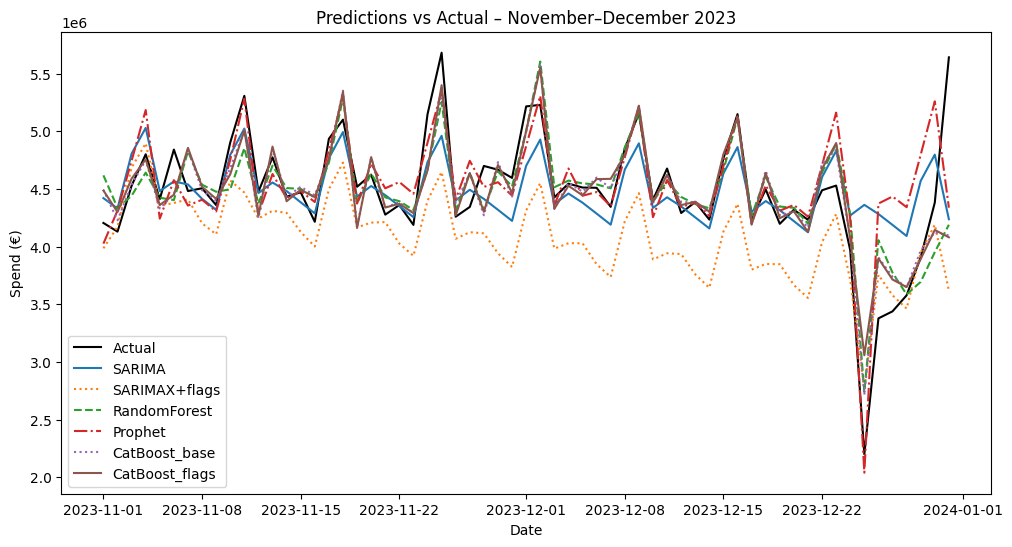

In [43]:
# Cell 10b: Comparatif Nov-Déc 2023
plt.figure(figsize=(12,6))
plt.plot(eval_df.index, eval_df['actual'],       label='Actual', color='black')
plt.plot(eval_df.index, eval_df['SARIMA'],       label='SARIMA', linestyle='-')
plt.plot(eval_df.index, eval_df['SARIMAX_exog'], label='SARIMAX+flags', linestyle=':')
plt.plot(eval_df.index, eval_df['RF'],           label='RandomForest', linestyle='--')
plt.plot(eval_df.index, eval_df['Prophet'],      label='Prophet', linestyle='-.')
plt.plot(eval_df.index, eval_df['CatBoost_base'],   label='CatBoost_base', linestyle=':')
plt.plot(eval_df.index, eval_df['CatBoost_flags'],  label='CatBoost_flags', linestyle='-')
plt.legend()
plt.title('Predictions vs Actual – November–December 2023')
plt.xlabel('Date'); plt.ylabel('Spend (€)')
plt.show()


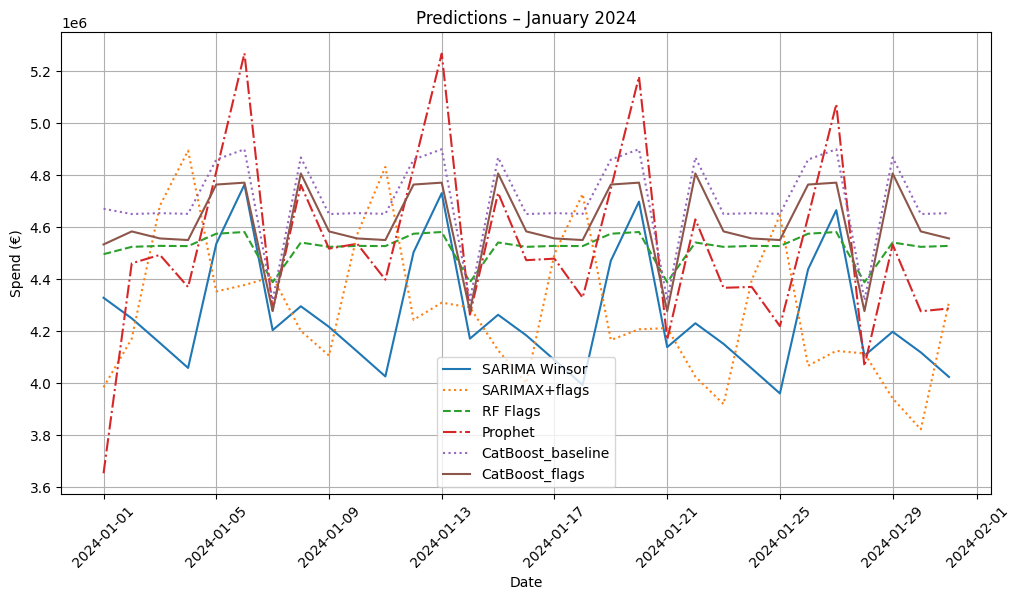

In [44]:
# Cell 11: Prédictions Janvier 2024


# 1) Préparation de l’index de janvier
jan_idx = pd.date_range('2024-01-01','2024-01-31', freq='D')

plt.figure(figsize=(12,6))

# SARIMA Winsor
plt.plot(pred_sarima_jan.index, pred_sarima_jan,
         label='SARIMA Winsor', linestyle='-')

# SARIMAX + flags
plt.plot(pred_exog_jan.index, pred_exog_jan,
         label='SARIMAX+flags', linestyle=':')

# RandomForest + flags
plt.plot(pred_rf_jan.index, pred_rf_jan,
         label='RF Flags', linestyle='--')

# Prophet
plt.plot(pred_prophet_jan.index, pred_prophet_jan,
         label='Prophet', linestyle='-.')

# CatBoost baseline (lags only)
plt.plot(jan_idx, pred_cb_base_jan,
         label='CatBoost_baseline', linestyle=':')

# CatBoost + flags & lags
plt.plot(jan_idx, pred_cb2_jan,
         label='CatBoost_flags', linestyle='-')

plt.title('Predictions – January 2024')
plt.xlabel('Date')
plt.ylabel('Spend (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


## Etape 5 : Plan d’industrialisation et suivi


Pour passer du prototype à un système de forecasting fiable et scalable, voici mon plan en quatre volets :

1. **Pipeline MLOps & Orchestration**  
   - **Airflow** (ou Kedro, Prefect…) pour automatiser les étapes :  
     - Ingestion quotidienne des nouvelles données  
     - Pré-processing (vérification des schémas, gestion des dates manquantes et des outliers)  
     - Training / scoring du modèle  
   - **CI/CD** via GitHub Actions / GitLab CI :  
     - Exécution automatique des notebooks/scripts,  
     - Tests unitaires et end-to-end (nbconvert --execute),  
     - Publication de l’image Docker sur un registry.

2. **Conteneurisation & Déploiement**  
   - **Docker** : emballer l’environnement Python (librairies, versions exactes) pour garantir une reproductibilité totale.  
   - **Kubernetes** :  
     - Jobs batch pour le ré-entraînement mensuel,  
     - Services REST (FastAPI/Flask) pour les prédictions en temps réel ou par lot.

3. **Monitoring & Versioning**  
   - **MLflow** pour tracer chaque entraînement :  
     - Paramètres du modèle, métriques (MAE, MAPE), artefacts (plots, CSV).  
   - **Grafana + Prometheus** (ou Evidently.ai) pour surveiller :  
     - **Data drift** : distribution journalière des features (outliers, saisonnalité),  
     - **Model drift** : suivi continu du MAE/ MAPE sur un échantillon de production, alertes si la performance se dégrade.

4. **Ré-entraînement & Gouvernance**  
   - **Scheduling mensuel** du pipeline dès que les données du mois précédent sont disponibles.  
   - **Tests automatisés** (unitaires + intégration) pour valider la qualité de chaque composant du pipeline.  
   - **Rollback** : capacité à revenir à la version précédente du modèle en cas d’anomalie détectée.

5. **Organisation & Rôles**  
   - **Data Engineer** : mise en place et maintenance du pipeline ETL, qualité des données.  
   - **Data Scientist** : feature engineering, modélisation, tests statistiques.  
   - **MLOps Engineer** : conteneurisation, orchestration, monitoring, déploiement continu.  



## Etape 6 : Cas client Heineken 

## Approche Test Innovation “Verre vs Alu”

**Contexte & Données**  
- 10 ans de données transactionnelles au niveau ticket-ligne (SKU, attributs produits, client, magasin, date)  
- Granularité jour × magasin pour le chiffre d’affaires total et par catégorie

---

**Cas 1 : Magasins tests déjà définis**  
1. **Construction du panel** :  
   - 5 magasins tests vs 5 magasins contrôle similaires (surface, profil clients, historique de ventes)  
2. **Difference-in-Differences** :  
   - Période pré : mai–juin 2024  
   - Période post : juillet–août 2024  
   - Régression panel :  
     $Y_{i,t} = \alpha_i + \delta_t + \beta\,(Test_i \times Post_t) + \epsilon_{i,t}$.  
     où **β** est l’effet causal du passage au verre  
3. **Robustesse** :  
   - Placebo tests (autres périodes)  
   - Ajustement sur promotions, météo, saisonnalités hebdo/mensuelles

---

**Cas 2 : Choix des magasins tests**  
1. **Clustering** : regrouper les 1000+ magasins selon profil (CA moyen, mix produits, taille, zone géographique)  
2. **Matching / Sélection** : choisir 5 magasins tests et 5 témoins par cluster pour minimiser l’hétérogénéité  
3. **Power analysis** : vérifier que l’échantillon détecte un lift minimal (ex. +5 % de CA) avec 80 % de puissance

---

**Décision & Recommandation**  
- Si **β > 0** et **significatif** (p < 0,05) : rollout progressif sur tout le réseau  
- Sinon : étendre le test à d’autres clusters ou ajuster packaging/prix avant déploiement 

> **Note**: The panel regression accounts for both store-specific fixed effects ($\alpha_i$) and time-specific shocks ($\delta_t$).  
> The interaction term ($Test_i \times Post_t$) isolates the causal impact of the treatment.  
> The coefficient $\beta$ is interpreted as the average treatment effect.



## Exemple chiffré – Impact du verre vs alu

**Contexte**  
- 10 ans de données quotidiennes de CA par magasin  
- Mai–juin 2024 (alu) : CA moyen = 100 000 €/mois  
- Juil.–août 2024 (verre) : CA moyen = 110 000 €/mois  

---

### Cas 1 : Magasins tests déjà choisis

**Choix du groupe témoin**  
- 5 magasins contrôle au CA moyen similaire (100 000 € en mai–juin)

**Mesure pré/post**  
- **Témoin** : 100 000 € → 102 000 € (+2 000 €)  
- **Test**    : 100 000 € → 110 000 € (+10 000 €)

**Difference-in-Differences (DiD)**  
- Évolution test   = +10 000 €  
- Évolution témoin = +2 000 €  
- **Effet causal** = 10 000 € − 2 000 € = **+ 8 000 €**  

> Remplacer l’alu par le verre génère en moyenne **+ 8 000 €/mois** et par magasin, hors autres facteurs.

---

### Cas 2 : Choix libre des magasins tests

**Approche 1 – Clustering & tirage**  
1. Regrouper les 1 000+ magasins par profil (CA moyen, mix produits, zone)  
2. Dans chaque cluster, tirer au sort 5 magasins tests et 5 témoins  

**Approche 2 – Propensity Score Matching**  
1. Estimer la probabilité d’être traité (verre) à partir des caractéristiques  
2. Apparier chaque magasin test à un témoin ayant un score similaire  

Appliquer ensuite **la même formule DiD** sur l’échantillon apparié pour mesurer β.

---

### Décision  
- **Si β > 0** et **p-value < 0,05** : déploiement progressif sur tout le réseau  
- **Sinon** :  
  - Étendre le test à d’autres clusters  
  - Ajuster le packaging/prix et relancer l’expérimentation  
